<strong>Aluno</strong>: Victor São Paulo Ruela



In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn.datasets import load_breast_cancer

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from IPython.display import clear_output
import random


# Benchmark RBFs e ELM

Neste trabalho é feita uma comparação entre modelos RBF com duas abordagens distintas para definição do centros e raios, e o algoritmo ELM. A primeira abordagem consiste no inicialização pelo algoritmo k-means, e a segunda de forma aleatória. Esta última consistiu nos seguintes passos:

1. Escolher $p$ pontos aleatórios dos dados de entrada
2. Definir o centróide dos dados de entrada e calcular a distância de todos os pontos a esse centróide
3. Amostrar um raio de uma distribuição normal estimada a partir do vetor de distâncias calculado anteriormente
    3.1 Os valores mínimo e máximo são usados para validar os valores amostrados para o raio
    3.2 Assume-se que a distribuição das distâncias é normal para simplificar a estratégia, embora não exista garantias em relação a isso ser respeitado na prática
4. Para cada $p$, calcular a matriz de covariâncias dos dados que pertencem à respectiva hiper-esfera 

A implementação dos algoritmos é apresentada a seguir, seguida do carregamento e pré-processamento das bases de dados a serem utilizadas.


In [ ]:
class RBF:
    def __init__(self, p, center_estimation='kmeans'):
        self.p = p
        self.center_estimation = center_estimation

    def apply_transformation(self, X):
        N, n = X.shape
        H = np.zeros((N, self.p))
        for j in range(N):
            for i in range(self.p):
                mi = self.centers_[i, :]
                covi = self.cov_[i] + 0.001 * np.eye(n)
                H[j, i] = self.gaussian_kernel(X[j, :], mi, covi, n)
        return H

    def predict(self, X):
        N, _ = X.shape

        H = self.apply_transformation(X)
        H_aug = np.hstack((np.ones((N, 1)), H))
        yhat = H_aug @ self.coef_

        return yhat

    def gaussian_kernel(self, X, m, K, n):
        if n == 1:
            r = np.sqrt(float(K))
            px = (1/(np.sqrt(2*np.pi*r*r)))*np.exp(-0.5 * (float(X-m)/r)**2)
            return px
        else:
            center_distance = (X - m).reshape(-1, 1)
            normalization_factor = np.sqrt(((2*np.pi)**n)*np.linalg.det(K))
            dist = float(
                np.exp(-0.5 * (center_distance.T @ (np.linalg.inv(K)) @ center_distance)))
            return dist / normalization_factor
            
    def make_centers(self, X):
        N, n = X.shape

        if(self.center_estimation == 'kmeans'):
            kmeans = KMeans(n_clusters=self.p).fit(X)
            self.centers_ = kmeans.cluster_centers_
            # estimate covariance matrix for all centers
            clusters = kmeans.predict(X)
            covlist = []
            for i in range(self.p):
                xci = X[clusters == i, :]
                covi = np.cov(xci, rowvar=False) if n > 1 else np.asarray(
                    np.var(xci))
                covlist.append(covi)
            self.cov_ = covlist
        elif (self.center_estimation == 'random'):
            random_idx = random.sample(range(N), self.p)
            # define the maximum radius possible from the data
            data_center = np.mean(X, axis=0).reshape(1,-1)
            dist_center = np.linalg.norm(X - data_center, axis=1)
            max_radius = np.max(dist_center)
            min_radius = np.min(dist_center)
            mean_radius = np.mean(dist_center)
            std_radius = np.std(dist_center)

            # Now define random radius values
            random_radius = np.random.normal(loc=mean_radius, scale=std_radius, size=self.p)
            random_radius = np.maximum(random_radius, min_radius)
            random_radius = np.minimum(random_radius, max_radius)

            covlist = []
            centers = []
            for i in range(self.p):
                # Get the two random points from list
                center = X[random_idx[i], :]
                points_within_radius = np.linalg.norm(X - center, axis=1) <= random_radius[i]
                xci = X[points_within_radius, :]
                covi = np.cov(xci, rowvar=False) if n > 1 else np.asarray(np.var(xci))

                covlist.append(covi)
                centers.append(center)
            self.cov_ = covlist
            self.centers_ = np.asarray(centers)

        else:
            raise ValueError

    def fit(self, X, y):
        N, _ = X.shape

        # define centers
        self.make_centers(X)
        # calculate H matrix
        H = self.apply_transformation(X)

        H_aug = np.hstack((np.ones((N, 1)), H))
        self.coef_ = (np.linalg.inv(H_aug.T @ H_aug) @ H_aug.T) @ y
        self.H_ = H

        return self

class ELM:
    def __init__(self, p=5):
        self.p = p

    def predict(self, X):
        N, _ = X.shape
        x_aug = np.hstack((-np.ones((N, 1)), X))
        H = np.tanh(x_aug @ self.Z_)
        return H @ self.coef_

    def fit(self, X, y):
        # augment X
        N, n = X.shape
        x_aug = np.hstack((-np.ones((N, 1)), X))
        # create initial Z matrix
        Z = np.random.uniform(-0.5, 0.5, (n+1, self.p))
        # apply activation function: tanh
        H = np.tanh(x_aug @ Z)
        # calculate the weights
        w = np.linalg.pinv(H) @ y
        # store fitted data
        self.coef_ = w
        self.Z_ = Z

        return self

In [ ]:
# load the breast cancer data
X_bc, y_bc = load_breast_cancer(return_X_y = True)
# convert the classes to -1 or 1
y_bc = pd.Series(y_bc).map({0:-1,1:1}).to_numpy()
# scale the data
scaler_bc = MinMaxScaler()
X_bc = scaler_bc.fit_transform(X_bc)

In [ ]:
# load the statlog(heart) dataset
heart_df = pd.read_csv('heart.dat', sep=' ', header=None)
X_hd, y_hd = heart_df.iloc[:,:-1].to_numpy(), heart_df.iloc[:,-1].map({2:1, 1:-1}).to_numpy()
# scale the data
scaler_hd = MinMaxScaler()
X_hd = scaler_hd.fit_transform(X_hd)

In [ ]:
def train_model(X_train, y_train, X_test, y_test, neurons, reps=10, model='rbf-random'):
    accuracy_results = []
    accuracy_results_train = []
    for p in tqdm(neurons):
        accuracy_test = []
        accuracy_train = []
        for _ in range(reps):
            if(model == 'rbf-random'):
                classifier = RBF(p=p,center_estimation='random').fit(X_train, y_train)
            elif(model == 'rbf-kmeans'):
                classifier = RBF(p=p,center_estimation='kmeans').fit(X_train, y_train)
            elif(model == 'elm'):
                classifier = ELM(p=p).fit(X_train, y_train)
            else:
                raise ValueError('Invalid model name')
            
            yhat = np.sign(classifier.predict(X_test))
            yhat_train = np.sign(classifier.predict(X_train))
            # accuracy
            accuracy_test.append(accuracy_score(y_test, yhat))
            accuracy_train.append(accuracy_score(y_train, yhat_train))
            
        accuracy_results.append(np.mean(accuracy_test))
        accuracy_results_train.append(np.mean(accuracy_train))
    return accuracy_results, accuracy_results_train

def run_experiment(X, y, N=30, neurons=[5,10,30,50,100], model='rbf-random', plot=True, datasets=None):
    experiment_values_test = []
    experiment_values_train = []
    data_sets = {}
    for i in tqdm(range(N)):
        # split the data
        if(datasets == None):
            X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3)    
        else:
            X_train, y_train, X_test, y_test = datasets[i]
        
        data_sets[i] = (X_train, y_train, X_test, y_test)
        # run for every neuron
        test_values, train_values = train_model(X_train, y_train, X_test, y_test, neurons, reps=1, model=model)

        experiment_values_test.append(test_values)
        experiment_values_train.append(train_values)

    def convert_results(res, set): 
        df = pd.DataFrame(res, columns=neurons).melt(value_vars=neurons,value_name='Acurácia', var_name='Neurônios')
        df['Conjunto'] = set
        return df

    train_values_df = convert_results(experiment_values_train, 'Treino')
    test_values_df = convert_results(experiment_values_test, 'Teste')
    
    experiment_values_df = pd.concat([train_values_df, test_values_df], ignore_index=True)
    clear_output(wait=True)
    if (plot==True):
        # Plot the accuracy boxplots
        plt.figure(figsize=(8,5))
        sns.boxplot(data=experiment_values_df, x='Conjunto',y='Acurácia', hue='Neurônios', showfliers=False)
       

    return experiment_values_df, data_sets 

In [96]:
def plot_experiment_comparison(elm, rbfrandom, rbfkmeans):
    elm['Modelo'] = 'ELM'
    rbfrandom['Modelo'] = 'RBF - Aleatório'
    rbfkmeans['Modelo'] = 'RBF - k-means'

    sns.set(font_scale=2.5)
    results = pd.concat([elm, rbfkmeans, rbfrandom], ignore_index=True)
    sns.catplot(data=results, x='Conjunto',y='Acurácia', hue='Neurônios', col='Modelo', kind='box', showfliers=False, height=12, aspect=0.8)

## Parte 1: Base de dados Breast Cancer (Diagnostic)

Para este exercício será feita uma análise do algoritmo RBF com centros aleatórios, k-médias e o algoritmo ELM. O objetivo é avaliar o impacto do número de nerônios na sua capacidade de generalização e compará-los em relação à acurácia do modelo, a partir do seguinte experimento:

Nº de neurônios: $[5,10,30,50,100,150]$

* 1) Separar o conjunto entre testes e treinamento, na proporção de 30% para teste
* 2) Treinar o RBF Para cada quantidade de neurônios na lista 
* 3) Repetir os passos 1-2 20 vezes.

Uma rotina foi criada para a execução deste experimento, cujos resultados são exibidos abaixo no gráfico boxplot e tabela com a média e desvio padrão obtidos para a acurácia.

In [ ]:
results_bc_rbfrandom, datasets_bc = run_experiment(X_bc, y_bc,neurons=[5,10,30,50,100,150], N=20, model='rbf-random',plot=False)

In [ ]:
results_bc_rbfkmeans, _ = run_experiment(X_bc, y_bc,neurons=[5,10,30,50,100,150], N=20, model='rbf-kmeans', datasets=datasets_bc, plot=False)

In [ ]:
results_bc_elm, _ = run_experiment(X_bc, y_bc,neurons=[5,10,30,50,100,150], N=20, model='elm', datasets=datasets_bc,plot=False)

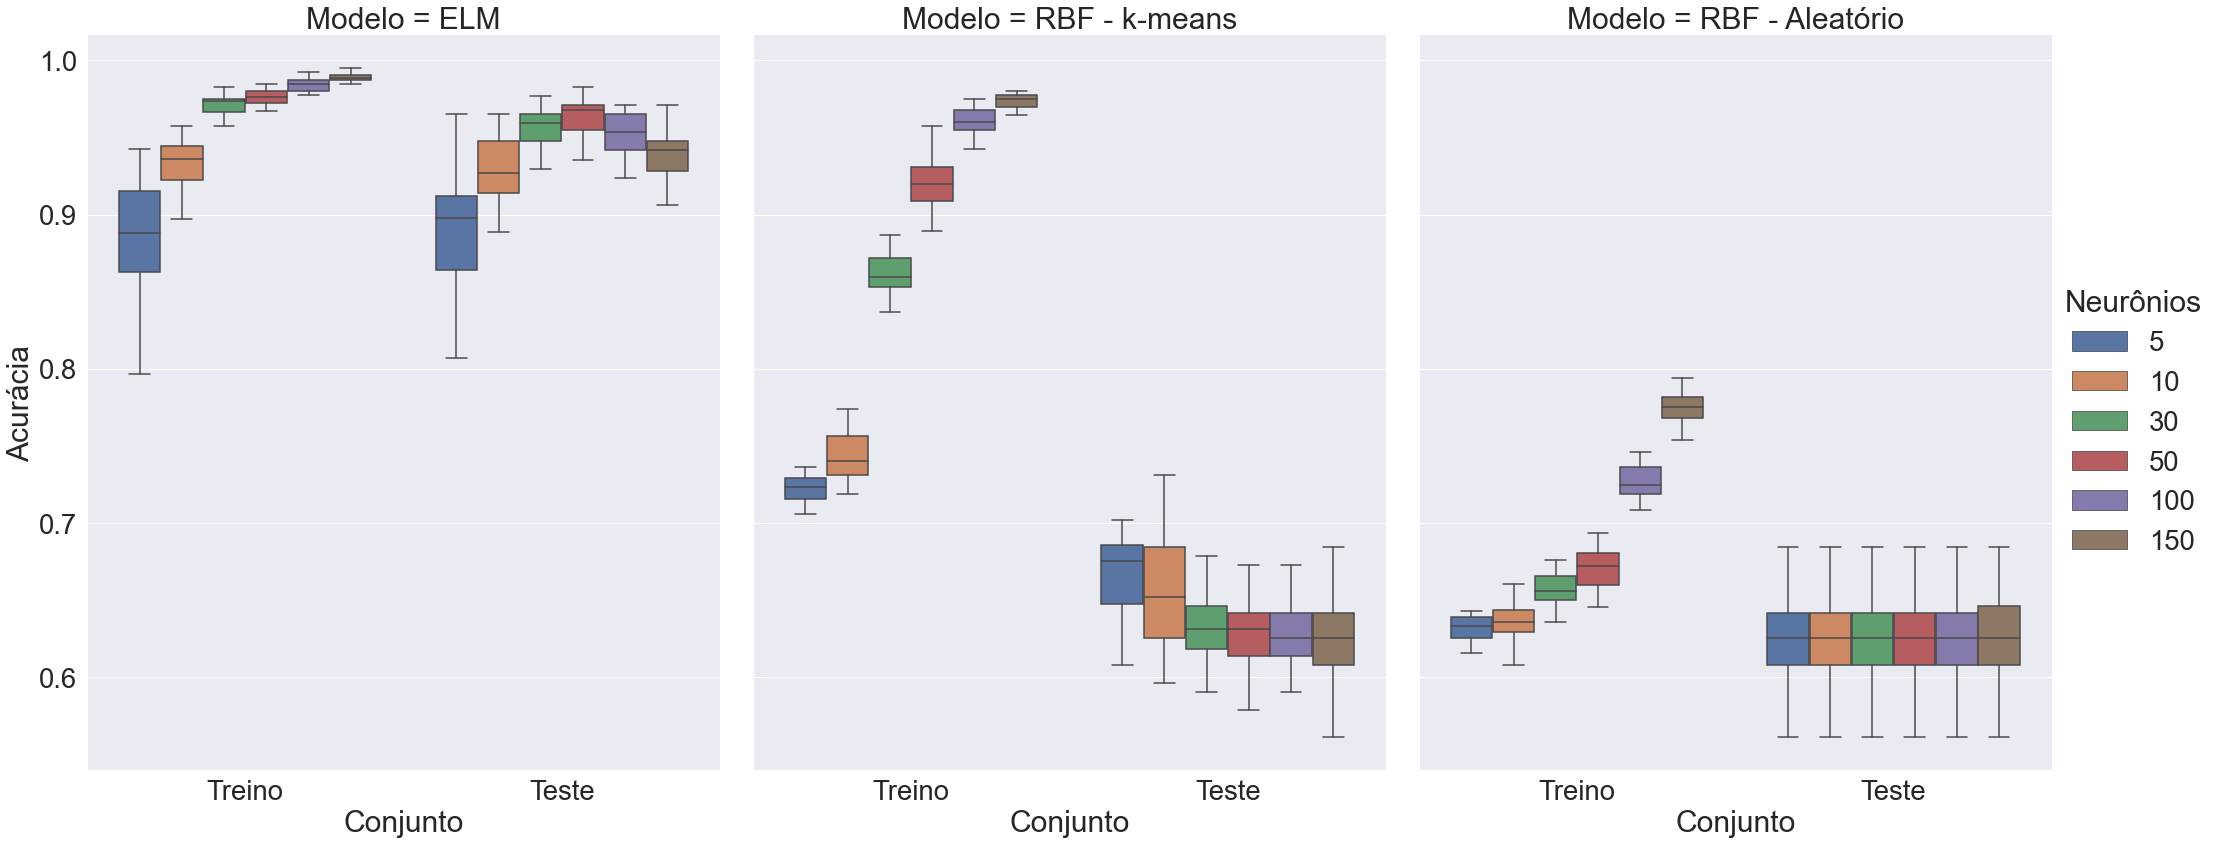

In [97]:
plot_experiment_comparison(results_bc_elm, results_bc_rbfrandom, results_bc_rbfkmeans)

A partir dos resultados acima, é possível concluir que:

* Para todos os modelos, a acurácia média de treinamento cresce proporcionalmente com o número de neurônios, conforme esperado. É interessante notar que o RBF com centros inicializados aleatoriamente possui desempenho bastante inferior ao RBF com k-means, uma vez que este consegue ficar em torno de 100% de acurário de treinamento com 100 neurônios.
* O ELM apresentou a melhor generalização, conseguir atingir cerca de 95% de acurácia de teste.
* Ambos os modelos RBF apresentaram generalização muito abaixo de desejado. Embora o RBF k-means consegue obter uma acurácia alta de treinamento com 100 neurônios, seu desempenho no conjunto de teste é muito baixo, cerca de 65%. Já o RBF aleatório não foi capaz de ultrapasar 80% de acurácia de treinamento, obtendo uma acurácia de teste quase constante em torno de 65%.
* O RBF k-means foi capaz de se adaptar melhor ao conjunto de treinamento, embora apresente a tendência de over-fitting. A inicialização aleatória não foi capaz de descrever todo o espaço de treinamento, uma vez que a acurácia de treinamento sempre se manteve muito baixa. Isso sugere que a abordagem escolhido não foi boa o suficiente e necessita de melhorias para conseguir representar todo o espaço de dados.
* O esforço computacional requerido pelo RBF cresce muito à medida em que aumentamos a quantidade de neurônios na camada escondida. O mesmo não foi observado para o ELM, o qual além de obter uma melhor generalização, necessitou de um tempo muito menor de treinamento.

## Parte 2: Base Statlog (Heart)

A mesma análise anterior é feita considerando a base de dados Statlog (Heart). O mesmo experimento é executado, considerando a rotina desenvolvida anteriormente. Os resultados são exibidos e analisados abaixo.

In [ ]:
results_hd_rbfrandom, datasets_hd = run_experiment(X_hd, y_hd,neurons=[5,10,30,50,100,150], N=20, model='rbf-random',plot=False)

In [ ]:
results_hd_rbfkmeans, _ = run_experiment(X_hd, y_hd,neurons=[5,10,30,50,100,150], N=20, datasets=datasets_hd, model='rbf-kmeans',plot=False)

In [ ]:
results_hd_elm, _ = run_experiment(X_hd, y_hd,neurons=[5,10,30,50,100,150], N=20, datasets=datasets_hd, model='elm',plot=False)

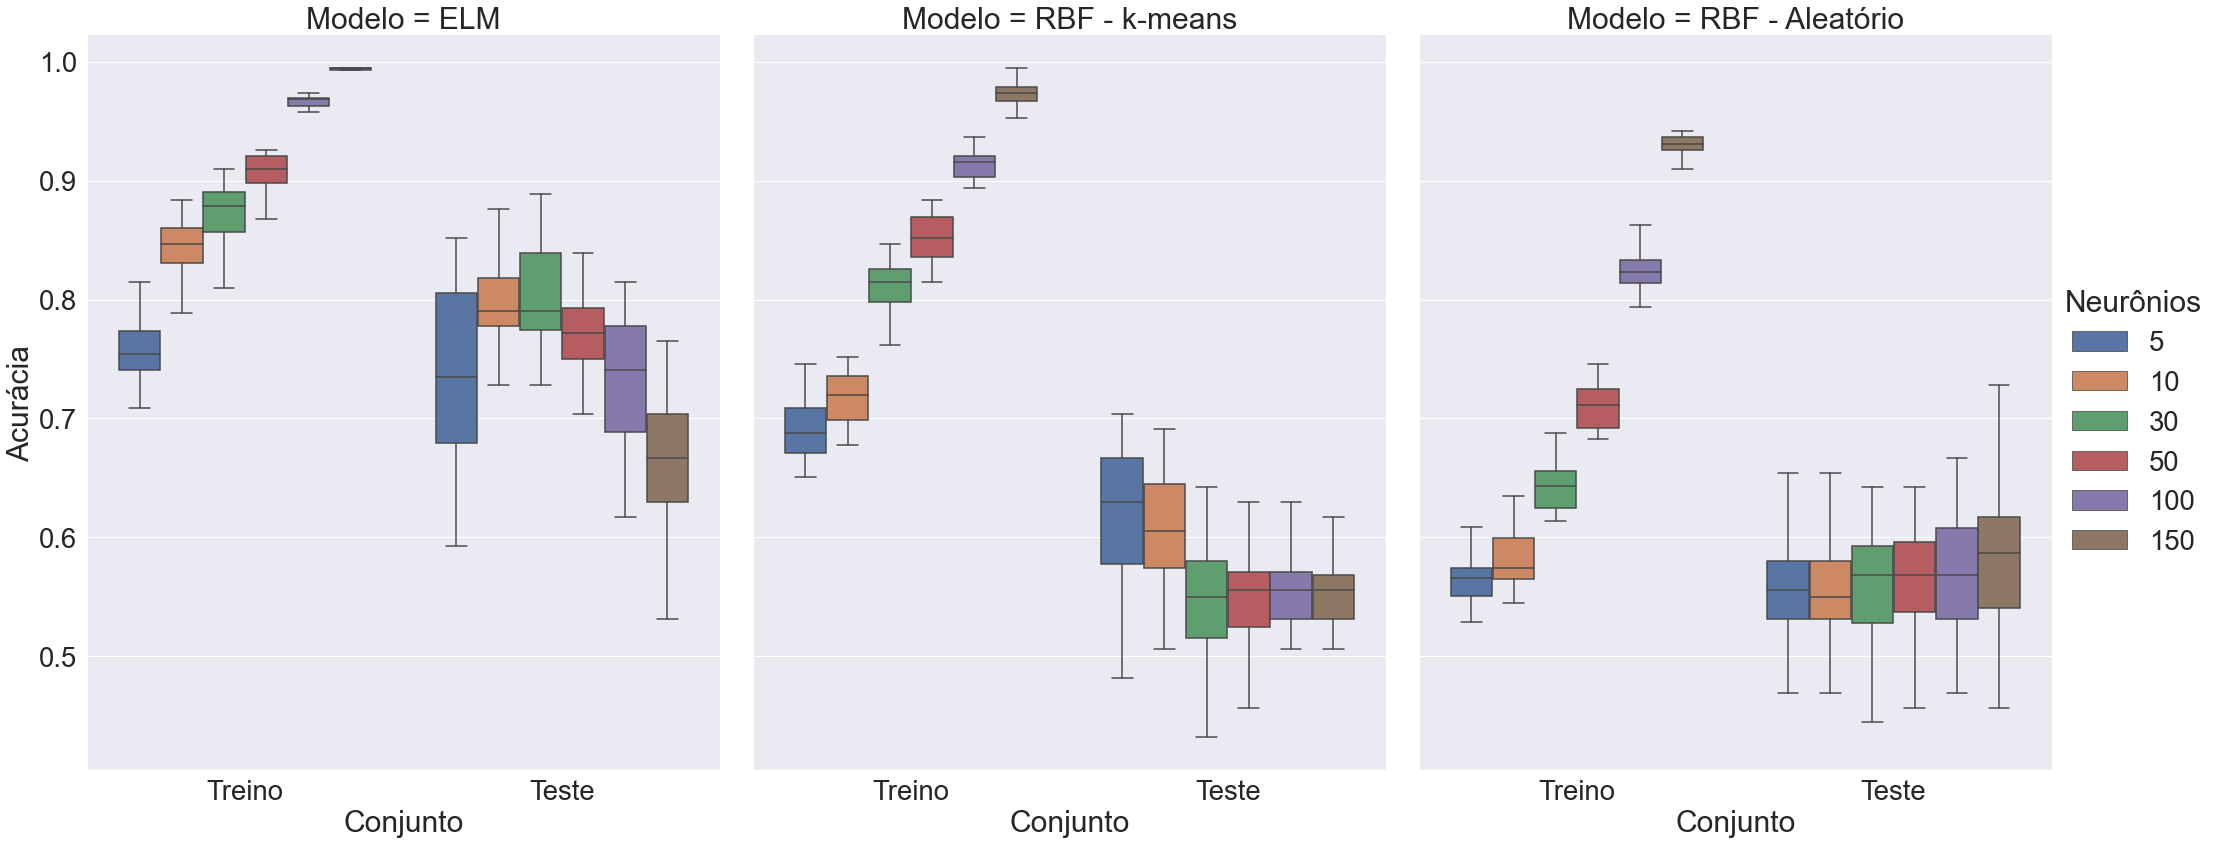

In [98]:
plot_experiment_comparison(results_hd_elm, results_hd_rbfrandom, results_hd_rbfkmeans)

A partir dos resultados acima, é possível concluir que:

* Para todos os modelos, a acurácia média de treinamento cresce proporcionalmente com o número de neurônios. Da mesma forma que o experimento anterior, o RBF com centros inicializados aleatoriamente possui desempenho bastante inferior ao RBF com k-means.
* O ELM apresentou a melhor generalização, conseguir atingir uma acurácia de teste superior aos modelos RBF.
* Ambos os modelos RBF apresentaram generalização cerca de 20% inferor ao ELM. Embora o RBF consigua obter uma acurácia alta de treinamento com 100 neurônios, seu desempenho no conjunto de teste é muito menor que 60%.
* O RBF k-means foi capaz de se adaptar melhor ao conjunto de treinamento em relação à inicialização aleatória. Embora há um aumento da acurácia de treinamento com o aumento da complexidade do modelo, para os dois modelos a acurácia de teste se manteve próxima da faixa dos 60%.
* É possível notar claramente a redução da generalização do RBF k-means com o aumento da complexidade do modelo. Porém, é interessante notar que para o RBF aleatório a acurácia de teste se manteve praticamente constante, indicando que o aumento da complexidade possuiu pouco efeito na sua capacidade de generalização.
* Extrapolando os resultados obtidos, os dois modelos RBF teriam desempenho similar para um número de neurônios bem alto, maior do que 100.

## Conclusões

Por meio dos experimentos realizados neste exercício, foi possível constatar que ELMs são capazes de obter um bom desempenho superior aos modelos RBF nas bases de dados avaliadas. Os modelos RBF, embora foram capazes de obter uma boa aproximação do conjunto de treinamento para uma quantidade grande de neurônios, não foram capazes de generalizar bem dados ainda não vistos. Além disso, foi possível observar que o RBF com k-médias possuiu desempenho ligeiramente melhor para o treinamento do que a estratégia de inicialização aleatória desenvolvida, embora forma capazes de generalizar de forma similar para o conjunto de teste. Isso indica que melhorar a etapa de inicialização dos centros e raios pode ser uma estratégia para melhorar o desempenho deste tipo de rede neural.

Por fim, outro resultado importante foi o esforço computacional demandado pelo RBF, o qual foi muito maior em relação ao do ELM. Isso mostra outra grande vantagem do ELM, além da sua capacidade de generalizar. A estratégia de inicialização indicada no enunciado foi implementada, porém sofria bastante de problemas numéricos com o aumento do número de neurônios, o que fez com que ela fosse desconsiderada e uma nova abordagem fosse proposta.